# Settings

In [1]:
EXP_NO = 1
SEED = 1
N_SPLITS = 5
CV = 'GroupKFold'
TARGET = 'target'
GROUP = 'art_series_id'

# Library

In [2]:
from collections import defaultdict
from functools import partial
import gc
import glob
import json
from logging import getLogger, StreamHandler, FileHandler, DEBUG, Formatter
import pickle
import os
import sys
import time

import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, mean_squared_error, cohen_kappa_score
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.pipeline import Pipeline

SCRIPTS_DIR = os.path.join('..', 'scripts')
assert(os.path.dirname(SCRIPTS_DIR))
if SCRIPTS_DIR not in sys.path: sys.path.append(SCRIPTS_DIR)
from folder import experiment_dir_of
from dataset import load_csvfiles, load_photofiles

In [3]:
pd.options.display.float_format = '{:.5f}'.format

# Prepare directory

In [4]:
output_dir = experiment_dir_of(EXP_NO)

In [5]:
output_dir

'..\\scripts\\..\\experiments\\exp001'

# Prepare logger

In [6]:
logger = getLogger(__name__)

In [7]:
'''Refference
https://docs.python.org/ja/3/howto/logging-cookbook.html
'''
logger.setLevel(DEBUG)
# create file handler which logs even debug messages
fh = FileHandler(os.path.join(output_dir, 'log.log'))
fh.setLevel(DEBUG)
# create console handler with a higher log level
ch = StreamHandler()
ch.setLevel(DEBUG)
# create formatter and add it to the handlers
formatter = Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(fh)
logger.addHandler(ch)
len(logger.handlers)

2

In [8]:
logger.info('Experiment no: {}'.format(EXP_NO))
logger.info('CV: {}'.format(CV))
logger.info('SEED: {}'.format(SEED))

2021-07-12 03:25:53,949 - __main__ - INFO - Experiment no: 1
2021-07-12 03:25:53,952 - __main__ - INFO - CV: GroupKFold
2021-07-12 03:25:53,953 - __main__ - INFO - SEED: 1


# Load csv files

In [9]:
SINCE = time.time()

In [10]:
logger.debug('Start loading csv files ({:.3f} seconds passed)'.format(time.time() - SINCE))
train, test, materials, techniques, sample_submission = load_csvfiles()
logger.debug('Complete loading csv files ({:.3f} seconds passed)'.format(time.time() - SINCE))

2021-07-12 03:25:53,982 - __main__ - DEBUG - Start loading csv files (0.017 seconds passed)
2021-07-12 03:25:54,004 - __main__ - DEBUG - Complete loading csv files (0.039 seconds passed)


In [11]:
train

,object_id,sorting_date,art_series_id,target
0,002bff09b09998d0be65,1631,509357f67692a6a45626,1
1,00309fb1ef05416f9c1f,1900,7987b47bbe5dc3039179,3
2,003a1562e97f79ba96dc,1834,ded7c3c9636708e5b14c,3
3,004890880e8e7431147b,1743,582ac2d7f0cef195b605,2
4,00718c32602425f504c1,1885,64c907f0c08dce4fb8e8,3
...,...,...,...,...
3932,ffa3259fff8e6f3818a1,1850,b187c294b0550acf049a,3
3933,ffd4d361756587883e48,1670,ad49a044770a48f860a6,1
3934,ffd794b7b311b7b7fd92,1789,f030a01b480b18a27be2,2
3935,ffe49bba69d06446de7e,1805,f5287bc84a05aada1d17,3


In [12]:
test

,object_id
0,0009e50b94be36ccad39
1,000bd5e82eb22f199f44
2,0015f44de1854f617516
3,00388a678879ba1efa27
4,005e1e7c6496902d23f3
...,...
5914,ffbe65ad399b632dcbd0
5915,ffd7b2d646c0320c311a
5916,ffdb93ede17d4501e530
5917,ffe111402004b0ed46b4


# Cross validation

In [13]:
# Splitter
if CV == 'GroupKFold':
    splitter = GroupKFold(n_splits=5)
    fold_indice = splitter.split(X=train, y=train[TARGET], groups=train[GROUP])
elif CV == 'StratifiedKFold':
    splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    fold_indice = splitter.split(X=train, y=train[TARGET])
else:
    raise ValueError(CV)

In [14]:
%%time
# Load and flatten test set images
logger.debug('Start loading test images ({:.3f} seconds passed)'.format(time.time() - SINCE))
test_images = load_photofiles(test['object_id'])
logger.debug('Complete loading test images ({:.3f} seconds passed)'.format(time.time() - SINCE))
test_images = test_images.reshape(test_images.shape[0], -1)

2021-07-12 03:25:54,060 - __main__ - DEBUG - Start loading test images (0.096 seconds passed)
2021-07-12 03:26:02,722 - __main__ - DEBUG - Complete loading test images (8.758 seconds passed)


Wall time: 8.66 s


In [15]:
for i, (train_index, valid_index) in enumerate(fold_indice):
    num_fold = i + 1
    logger.debug('Start fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))
    # Separate dataset into training/validation fold
#     train_index = train_index[:500]
    id_train = train.iloc[train_index]['object_id']
    X_train = load_photofiles(train.iloc[train_index]['object_id'])
    y_train = train.iloc[train_index][TARGET]
    id_valid = train.iloc[valid_index]['object_id']
    X_valid = load_photofiles(train.iloc[valid_index]['object_id'])
    y_valid = train.iloc[valid_index][TARGET]

    # Flatten image data (number of images * flattened image size)
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_valid = X_valid.reshape(X_valid.shape[0], -1)
    
    # Training
    logger.debug('Start training model ({:.3f} seconds passed)'.format(time.time() - SINCE))
    ## Dimension reducing
    decomposer = PCA(n_components=0.9, random_state=SEED)
    decomposer.fit(X_train)
    X_train = decomposer.transform(X_train)
    X_valid = decomposer.transform(X_valid)
    X_test = decomposer.transform(test_images)
    logger.debug('Complete dimension reducing ({:.3f} seconds passed)'.format(time.time() - SINCE))
    ## train estimator
    estimator = lgbm.LGBMClassifier(importance_type='gain', n_estimators=200, random_state=SEED,
                                    n_jobs=-1, class_weight='balanced')
    estimator.fit(X_train, y_train, feature_name=[f'comp{i + 1}' for i in range(X_train.shape[1])])
    logger.debug('Complete training ({:.3f} seconds passed)'.format(time.time() - SINCE))
    
    # Save model and prediction
    ## Training set
    pred_train = pd.DataFrame(data=estimator.predict_proba(X_train),
                              columns=estimator.classes_)
    pred_train['object_id'] = id_train.values
    filepath_fold_train = os.path.join(output_dir, f'cv_fold{num_fold}_training.csv')
    pred_train.to_csv(filepath_fold_train, index=False)
    logger.debug('Save training fold to {} ({:.3f} seconds passed)' \
                .format(filepath_fold_train, time.time() - SINCE))
    ## Validation set
    pred_valid = pd.DataFrame(data=estimator.predict_proba(X_valid),
                              columns=estimator.classes_)
    pred_valid['object_id'] = id_valid.values
    filepath_fold_valid = os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv')
    pred_valid.to_csv(filepath_fold_valid, index=False)
    logger.debug('Save validation fold to {} ({:.3f} seconds passed)' \
                .format(filepath_fold_valid, time.time() - SINCE))
    ## Test set
    pred_test = pd.DataFrame(data=estimator.predict_proba(X_test),
                             columns=estimator.classes_)
    pred_test['object_id'] = test['object_id'].values
    filepath_fold_test = os.path.join(output_dir, f'cv_fold{num_fold}_test.csv')
    pred_test.to_csv(filepath_fold_test, index=False)
    logger.debug('Save test result {} ({:.3f} seconds passed)' \
                 .format(filepath_fold_test, time.time() - SINCE))
    ## Model
    filepath_fold_model = os.path.join(output_dir, f'cv_fold{num_fold}_model.pickle')
    with open(filepath_fold_model, 'wb') as f:
        model = [decomposer, estimator]
        pickle.dump(model, f)
    logger.debug('Save model {} ({:.3f} seconds passed)'.format(filepath_fold_model, time.time() - SINCE))
    
    # Save memory
    del (model, decomposer, estimator, X_train, X_test, X_valid, y_train, y_valid,
         pred_train, pred_valid, pred_test)
    gc.collect()

    logger.debug('Complete fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

2021-07-12 03:26:02,760 - __main__ - DEBUG - Start fold 1 (8.796 seconds passed)
2021-07-12 03:26:08,041 - __main__ - DEBUG - Start training model (14.076 seconds passed)
2021-07-12 03:29:29,313 - __main__ - DEBUG - Complete dimension reducing (215.339 seconds passed)
2021-07-12 03:29:35,222 - __main__ - DEBUG - Complete training (221.257 seconds passed)
2021-07-12 03:29:35,391 - __main__ - DEBUG - Save training fold to ..\scripts\..\experiments\exp001\cv_fold1_training.csv (221.426 seconds passed)
2021-07-12 03:29:35,434 - __main__ - DEBUG - Save validation fold to ..\scripts\..\experiments\exp001\cv_fold1_validation.csv (221.469 seconds passed)
2021-07-12 03:29:35,557 - __main__ - DEBUG - Save test result ..\scripts\..\experiments\exp001\cv_fold1_test.csv (221.593 seconds passed)
2021-07-12 03:29:37,027 - __main__ - DEBUG - Save model ..\scripts\..\experiments\exp001\cv_fold1_model.pickle (223.063 seconds passed)
2021-07-12 03:29:37,573 - __main__ - DEBUG - Complete fold 1 (223.609 s

# Evaluation

In [16]:
rmse = partial(mean_squared_error, squared=False)

In [17]:
qwk = partial(cohen_kappa_score, labels=np.sort(train['target'].unique()), weights='quadratic')

In [18]:
@np.vectorize
def predict(proba_0: float, proba_1: float, proba_2: float, proba_3: float) -> int:
    return np.argmax((proba_0, proba_1, proba_2, proba_3))

In [19]:
assert(train['object_id'].duplicated().sum() == 0)
train.set_index('object_id', inplace=True)

In [20]:
metrics = defaultdict(list)

## Training set

In [21]:
pred_train_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    logger.debug('Evaluate cv result (training set) Fold {}'.format(num_fold))
    # Read cv result
    filepath_fold_train = os.path.join(output_dir, f'cv_fold{num_fold}_training.csv')
    pred_train_df = pd.read_csv(filepath_fold_train)
    pred_train_df['pred'] = predict(pred_train_df['0'], pred_train_df['1'],
                                    pred_train_df['2'], pred_train_df['3'])
    pred_train_df['actual'] = train.loc[pred_train_df['object_id'], TARGET].values
    print(confusion_matrix(pred_train_df['actual'], pred_train_df['pred'],
                           labels=np.sort(train['target'].unique())))
    loss = rmse(pred_train_df['actual'], pred_train_df['pred'])
    score = qwk(pred_train_df['actual'], pred_train_df['pred'])
    logger.debug('Loss: {}'.format(loss))
    logger.debug('Score: {}'.format(score))
    metrics['train_losses'].append(loss)
    metrics['train_scores'].append(score)
    pred_train_dfs.append(pred_train_df)

metrics['train_losses_avg'] = np.mean(metrics['train_losses'])
metrics['train_losses_std'] = np.std(metrics['train_losses'])
metrics['train_scores_avg'] = np.mean(metrics['train_scores'])
metrics['train_scores_std'] = np.std(metrics['train_scores'])

2021-07-12 03:42:50,613 - __main__ - DEBUG - Evaluate cv result (training set) Fold 1
2021-07-12 03:42:50,860 - __main__ - DEBUG - Loss: 0.0
2021-07-12 03:42:50,861 - __main__ - DEBUG - Score: 1.0
2021-07-12 03:42:50,862 - __main__ - DEBUG - Evaluate cv result (training set) Fold 2
2021-07-12 03:42:50,902 - __main__ - DEBUG - Loss: 0.0
2021-07-12 03:42:50,902 - __main__ - DEBUG - Score: 1.0
2021-07-12 03:42:50,903 - __main__ - DEBUG - Evaluate cv result (training set) Fold 3
2021-07-12 03:42:50,940 - __main__ - DEBUG - Loss: 0.0
2021-07-12 03:42:50,941 - __main__ - DEBUG - Score: 1.0
2021-07-12 03:42:50,942 - __main__ - DEBUG - Evaluate cv result (training set) Fold 4
2021-07-12 03:42:50,977 - __main__ - DEBUG - Loss: 0.0
2021-07-12 03:42:50,977 - __main__ - DEBUG - Score: 1.0
2021-07-12 03:42:50,978 - __main__ - DEBUG - Evaluate cv result (training set) Fold 5
2021-07-12 03:42:51,013 - __main__ - DEBUG - Loss: 0.0
2021-07-12 03:42:51,013 - __main__ - DEBUG - Score: 1.0


[[ 372    0    0    0]
 [   0  710    0    0]
 [   0    0 1206    0]
 [   0    0    0  861]]
[[ 381    0    0    0]
 [   0  733    0    0]
 [   0    0 1179    0]
 [   0    0    0  856]]
[[ 379    0    0    0]
 [   0  710    0    0]
 [   0    0 1235    0]
 [   0    0    0  826]]
[[ 372    0    0    0]
 [   0  706    0    0]
 [   0    0 1224    0]
 [   0    0    0  848]]
[[ 396    0    0    0]
 [   0  725    0    0]
 [   0    0 1200    0]
 [   0    0    0  829]]


In [22]:
pred_train = pd.concat(pred_train_dfs).groupby('object_id').sum()
pred_train = pred_train / N_SPLITS
pred_train['pred'] = predict(pred_train['0'], pred_train['1'], pred_train['2'], pred_train['3'])
pred_train['actual'] = train.loc[pred_train.index, TARGET].values
pred_train

,0,1,2,3,pred,actual
object_id,,,,,,
002bff09b09998d0be65,0.00007,0.79764,0.00134,0.00096,1,1
00309fb1ef05416f9c1f,0.00012,0.00143,0.00150,0.79695,3,3
003a1562e97f79ba96dc,0.00021,0.00103,0.00116,0.79759,3,3
004890880e8e7431147b,0.00009,0.00390,0.79381,0.00220,2,2
00718c32602425f504c1,0.00022,0.00141,0.00261,0.79576,3,3
...,...,...,...,...,...,...
ffa3259fff8e6f3818a1,0.00006,0.00075,0.00104,0.79815,3,3
ffd4d361756587883e48,0.00024,0.79713,0.00146,0.00117,1,1
ffd794b7b311b7b7fd92,0.00016,0.00086,0.79676,0.00222,2,2


In [23]:
print(confusion_matrix(pred_train['actual'], pred_train['pred'], labels=np.sort(train['target'].unique())))
loss = rmse(pred_train['actual'], pred_train['pred'])
score = qwk(pred_train['actual'], pred_train['pred'])
metrics['train_loss'] = loss
metrics['train_score'] = score
logger.info('Training loss: {}'.format(loss))
logger.info('Training score'.format(score))

2021-07-12 03:42:51,085 - __main__ - INFO - Training loss: 0.0
2021-07-12 03:42:51,086 - __main__ - INFO - Training score


[[ 475    0    0    0]
 [   0  896    0    0]
 [   0    0 1511    0]
 [   0    0    0 1055]]


In [24]:
pred_train.to_csv(os.path.join(output_dir, 'prediction_train.csv'))
logger.debug('Write cv result to {}'.format(os.path.join(output_dir, 'prediction_train.csv')))

2021-07-12 03:42:51,125 - __main__ - DEBUG - Write cv result to ..\scripts\..\experiments\exp001\prediction_train.csv


## Validation set

In [25]:
pred_valid_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    logger.debug('Evaluate cv result (validation set) Fold {}'.format(num_fold))
    # Read cv result
    filepath_fold_valid = os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv')
    pred_valid_df = pd.read_csv(filepath_fold_valid)
    pred_valid_df['pred'] = predict(pred_valid_df['0'], pred_valid_df['1'],
                                    pred_valid_df['2'], pred_valid_df['3'])
    pred_valid_df['actual'] = train.loc[pred_valid_df['object_id'], TARGET].values
    print(confusion_matrix(pred_valid_df['actual'], pred_valid_df['pred'],
                           labels=np.sort(train['target'].unique())))
    loss = rmse(pred_valid_df['actual'], pred_valid_df['pred'])
    score = qwk(pred_valid_df['actual'], pred_valid_df['pred'])
    logger.debug('Loss: {}'.format(loss))
    logger.debug('Score: {}'.format(score))
    metrics['valid_losses'].append(loss)
    metrics['valid_scores'].append(score)
    pred_valid_dfs.append(pred_valid_df)
    
metrics['valid_losses_avg'] = np.mean(metrics['valid_losses'])
metrics['valid_losses_std'] = np.std(metrics['valid_losses'])
metrics['valid_scores_avg'] = np.mean(metrics['valid_scores'])
metrics['valid_scores_std'] = np.std(metrics['valid_scores'])

2021-07-12 03:42:51,145 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 1
2021-07-12 03:42:51,172 - __main__ - DEBUG - Loss: 1.1008764390294454
2021-07-12 03:42:51,173 - __main__ - DEBUG - Score: 0.2785404762817809
2021-07-12 03:42:51,173 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 2
2021-07-12 03:42:51,198 - __main__ - DEBUG - Loss: 1.0579647159057446
2021-07-12 03:42:51,198 - __main__ - DEBUG - Score: 0.2800865119285365
2021-07-12 03:42:51,199 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 3
2021-07-12 03:42:51,221 - __main__ - DEBUG - Loss: 1.0386434315445914
2021-07-12 03:42:51,222 - __main__ - DEBUG - Score: 0.313004389324554
2021-07-12 03:42:51,223 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 4
2021-07-12 03:42:51,240 - __main__ - DEBUG - Loss: 1.0711653334277973
2021-07-12 03:42:51,240 - __main__ - DEBUG - Score: 0.32939364686632155
2021-07-12 03:42:51,241 - __main__ - DEBUG - Evaluate cv result (validation set) Fol

[[ 19  20  33  31]
 [  7  48  89  42]
 [  0  35 197  73]
 [  2  18  62 112]]
[[ 11  29  31  23]
 [  4  44  81  34]
 [  1  50 209  72]
 [  5  16  66 112]]
[[ 11  28  35  22]
 [  7  60  92  27]
 [  1  29 209  37]
 [  4  20  90 115]]
[[ 16  31  30  26]
 [ 11  49  89  41]
 [  4  24 186  73]
 [  1  14  76 116]]
[[ 19  13  27  20]
 [ 12  47  67  45]
 [  7  43 203  58]
 [  5  18  70 133]]


In [26]:
pred_valid = pd.concat(pred_valid_dfs).groupby('object_id').sum()
pred_valid = pred_valid / N_SPLITS
pred_valid['pred'] = predict(pred_valid['0'], pred_valid['1'], pred_valid['2'], pred_valid['3'])
pred_valid['actual'] = train.loc[pred_valid.index, TARGET].values
pred_valid

,0,1,2,3,pred,actual
object_id,,,,,,
002bff09b09998d0be65,0.00796,0.07626,0.08470,0.03109,2,1
00309fb1ef05416f9c1f,0.02007,0.07187,0.09236,0.01570,2,3
003a1562e97f79ba96dc,0.00664,0.00259,0.02743,0.16333,3,3
004890880e8e7431147b,0.00160,0.05659,0.12008,0.02172,2,2
00718c32602425f504c1,0.00038,0.01885,0.13312,0.04764,2,3
...,...,...,...,...,...,...
ffa3259fff8e6f3818a1,0.00012,0.00357,0.00363,0.19268,3,3
ffd4d361756587883e48,0.00381,0.00852,0.10254,0.08513,2,1
ffd794b7b311b7b7fd92,0.00324,0.01220,0.15592,0.02864,2,2


In [27]:
print(confusion_matrix(pred_valid['actual'], pred_valid['pred'], labels=np.sort(train['target'].unique())))
loss = rmse(pred_valid['actual'], pred_valid['pred'])
score = qwk(pred_valid['actual'], pred_valid['pred'])
metrics['valid_loss'] = loss
metrics['valid_score'] = score
logger.info('Validatino loss: {}'.format(loss))
logger.info('Validatino score: {}'.format(score))

2021-07-12 03:42:51,323 - __main__ - INFO - Validatino loss: 1.0649470729686694
2021-07-12 03:42:51,324 - __main__ - INFO - Validatino score: 0.30237816484399205


[[  76  121  156  122]
 [  41  248  418  189]
 [  13  181 1004  313]
 [  17   86  364  588]]


In [28]:
pred_valid.to_csv(os.path.join(output_dir, 'prediction_valid.csv'))
logger.debug('Write cv result to {}'.format(os.path.join(output_dir, 'prediction_valid.csv')))

2021-07-12 03:42:51,364 - __main__ - DEBUG - Write cv result to ..\scripts\..\experiments\exp001\prediction_valid.csv


In [29]:
with open(os.path.join(output_dir, 'metrics.json'), 'w') as f:
    json.dump(dict(metrics), f)
logger.debug('Write metrics to {}'.format(os.path.join(output_dir, 'metrics.json')))

2021-07-12 03:42:51,385 - __main__ - DEBUG - Write metrics to ..\scripts\..\experiments\exp001\metrics.json


# Prediction

In [41]:
pred_test_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    # Read cv result
    filepath_fold_test = os.path.join(output_dir, f'cv_fold{num_fold}_test.csv')
    pred_test_df = pd.read_csv(filepath_fold_test)
    pred_test_dfs.append(pred_test_df)

In [42]:
pred_test = pd.concat(pred_test_dfs).groupby('object_id').sum()
pred_test = pred_test / N_SPLITS
pred_test['pred'] = predict(pred_test['0'], pred_test['1'], pred_test['2'], pred_test['3'])
pred_test

,0,1,2,3,pred
object_id,,,,,
0009e50b94be36ccad39,0.00436,0.50680,0.34465,0.14419,1
000bd5e82eb22f199f44,0.00931,0.40002,0.20612,0.38455,1
0015f44de1854f617516,0.03310,0.25407,0.57125,0.14159,2
00388a678879ba1efa27,0.00476,0.13998,0.39015,0.46511,3
005e1e7c6496902d23f3,0.14452,0.43917,0.34946,0.06685,1
...,...,...,...,...,...
ffbe65ad399b632dcbd0,0.00038,0.00268,0.05400,0.94293,3
ffd7b2d646c0320c311a,0.18447,0.35204,0.41701,0.04648,2
ffdb93ede17d4501e530,0.00428,0.38781,0.49243,0.11549,2


In [43]:
test['target'] = pred_test.loc[test['object_id'], 'pred'].values
test = test[['target']]
test

,target
0,1
1,1
2,2
3,3
4,1
...,...
5914,3
5915,2
5916,2
5917,2


In [44]:
sample_submission

,target
0,3
1,1
2,3
3,3
4,0
...,...
5914,2
5915,1
5916,1
5917,3


In [45]:
test.to_csv(os.path.join(output_dir, f'{str(EXP_NO).zfill(3)}_submission.csv'), index=True)
logger.debug('Write submission to {}'.format(os.path.join(output_dir, f'{str(EXP_NO).zfill(3)}_submission.csv')))

2021-07-12 03:48:22,664 - __main__ - DEBUG - Write submission to ..\scripts\..\experiments\exp001\001_submission.csv


C:\Users\nndropout\miniconda3\envs\img-beginner\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
2021-07-12 03:48:22,876 - __main__ - DEBUG - Write figure to ..\scripts\..\experiments\exp001\prediction.png


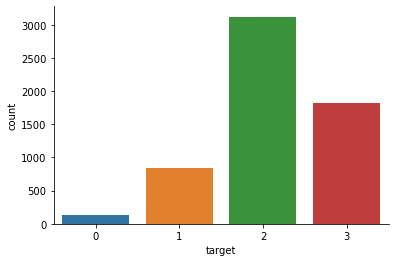

In [46]:
fig = plt.figure()
sns.countplot(test['target'])
sns.despine()
fig.savefig(os.path.join(output_dir, 'prediction.png'))
logger.debug('Write figure to {}'.format(os.path.join(output_dir, 'prediction.png')))